# XAI(Explainable AI): Kernel SHAP for Classification

본 핸즈온에서는 앙상블과 같은 블랙 박스 모델을 설명하는 데 적합한 SHAP(SHapley Additive exPlanations)을 사용하는 예시를 보여줍니다. SHAP은 전체 셋의 feature importance가 아니라 각 샘플 데이터마다 예측에 얼마나 기여했는지 정량화가 가능합니다.

## SHAP(SHapley Additive exPlanations)

SHAP에 대한 심화 주제는 아래 논문과 링크를 참조하세요
- [A Unified Approach to Interpreting Model Predictions] Lundberg, Scott M., and Su-In Lee Advances in Neural Information Processing Systems. 2017.
- Interpretable ML Book (SHAP chapter): http://christophm.github.io/interpretable-ml-book/shap.html

In [1]:
%load_ext autoreload
%autoreload 2
!pip install -qU shap

In [2]:
from autogluon.tabular import TabularDataset, TabularPredictor
import pandas as pd
import numpy as np
import sklearn
import shap
shap.initjs()

import warnings
warnings.filterwarnings('ignore')

<br>

## 1. Data preparation and Training

In [3]:
N_SUBSAMPLE = 500  # subsample datasets for faster demo
N_TEST = 50
NSHAP_SAMPLES = 10  # how many samples to use to approximate each Shapely value, larger values will be slower

train_data = TabularDataset('https://autogluon.s3.amazonaws.com/datasets/Inc/train.csv')  # can be local CSV file as well, returns Pandas DataFrame
train_data = train_data.sample(N_SUBSAMPLE)
test_data = TabularDataset('https://autogluon.s3.amazonaws.com/datasets/Inc/test.csv')
test_data = test_data.sample(N_TEST)

label = 'class'

y_train = train_data[label]
y_test = test_data[label]
X_train = pd.DataFrame(train_data.drop(columns=[label]))
X_test = pd.DataFrame(test_data.drop(columns=[label]))

display(train_data.head())

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
18828,40,Federal-gov,219266,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,>50K
27445,18,?,79990,11th,7,Never-married,?,Own-child,White,Male,0,0,35,United-States,<=50K
12294,59,State-gov,354948,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,3103,0,40,United-States,>50K
22959,32,Private,164197,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,60,United-States,>50K
24860,65,?,106161,Assoc-acdm,12,Married-civ-spouse,?,Husband,White,Male,0,0,40,United-States,<=50K


In [4]:
predictor = TabularPredictor(label=label, problem_type='binary').fit(train_data, time_limit=20)

No path specified. Models will be saved in: "AutogluonModels/ag-20210318_004700/"
Beginning AutoGluon training ... Time limit = 20s
AutoGluon will save models to "AutogluonModels/ag-20210318_004700/"
AutoGluon Version:  0.1.0
Train Data Rows:    500
Train Data Columns: 14
Preprocessing data ...
NumExpr defaulting to 8 threads.
Selected class <--> label mapping:  class 1 =  >50K, class 0 =  <=50K
	Note: For your binary classification, AutoGluon arbitrarily selected which label-value represents positive ( >50K) vs negative ( <=50K) class.
	To explicitly set the positive_class, either rename classes to 1 and 0, or specify positive_class in Predictor init.
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    62465.42 MB
	Train Data (Original)  Memory Usage: 0.29 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of

	Ran out of time, stopping training early.


	0.25	 = Validation accuracy score
	8.94s	 = Training runtime
	0.4s	 = Validation runtime


Fitting model: WeightedEnsemble_L2 ... Training model for up to 19.89s of the -4.35s of remaining time.
	0.9	 = Validation accuracy score
	0.52s	 = Training runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 24.89s ...
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20210318_004700/")


<br>

## 2. Explain predictions

SHAP은 각 피쳐가 예측 결과에 "얼마나" 기여하는지 설명합니다. 구체적으로 baseline에서 positive 클래스의 예측 확률 간의 편차로 정량화되며,
신규 데이터에 대한 예측 시에는 훈련 데이터에 대한 평균 예측과 다른 각 피쳐가 예측에 얼마나 기여하는지 정량화합니다.

In [5]:
class AutogluonWrapper:
    def __init__(self, predictor, feature_names):
        self.ag_model = predictor
        self.feature_names = feature_names
    
    def predict_proba(self, X):
        if isinstance(X, pd.Series):
            X = X.values.reshape(1,-1)
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.feature_names)
        return self.ag_model.predict_proba(X)

피쳐의 baseline reference 값을 정의합니다. 

In [6]:
baseline = X_train.sample(100) # X_train.mode() could also be reasonable baseline for both numerical/categorical features rather than an entire dataset.

AutoGluon 예측 결과를 설명하기 위해 Kernel SHAP 값을 반환하는 KernelExplainer를 생성합니다.

In [7]:
ag_wrapper = AutogluonWrapper(predictor, X_train.columns)
explainer = shap.KernelExplainer(ag_wrapper.predict_proba, baseline)
print("Baseline prediction: ", np.mean(ag_wrapper.predict_proba(baseline)))  # this is the same as explainer.expected_value

Baseline prediction:   <=50K    0.722614
 >50K     0.277386
dtype: float64


### SHAP for single datapoint

훈련 데이터셋 내의 임의의 데이터 포인트에 대해 SHAP을 plot해 보겠습니다.

In [8]:
ROW_INDEX = 0  # index of an example datapoint
single_datapoint = X_train.iloc[[ROW_INDEX]]
single_prediction = ag_wrapper.predict_proba(single_datapoint)
shap_values_single = explainer.shap_values(single_datapoint, nsamples=NSHAP_SAMPLES)

  0%|          | 0/1 [00:00<?, ?it/s]

num_full_subsets = 0
remaining_weight_vector = [0.324082 0.175545 0.127669 0.105327 0.093624 0.087772 0.085981]
num_paired_subset_sizes = 6
weight_left = 1.0
np.sum(w_aug) = 14.000000000000002
np.sum(self.kernelWeights) = 1.0
phi = [-0.062224  0.        0.        0.        0.        0.       -0.08494   0.        0.        0.        0.
  0.        0.        0.      ]
np.sum(w_aug) = 14.000000000000002
np.sum(self.kernelWeights) = 1.0
phi = [0.062224 0.       0.       0.       0.       0.       0.08494  0.       0.       0.       0.       0.       0.
 0.      ]


In [9]:
shap.force_plot(explainer.expected_value[0], shap_values_single[0], X_train.iloc[ROW_INDEX,:])

In [10]:
shap.force_plot(explainer.expected_value[1], shap_values_single[1], X_train.iloc[ROW_INDEX,:])

### SHAP for dataset

테스트 데이터셋의 모든 데이터 포인트에 대해서도 SHAP을 plot할 수 있습니다.

In [11]:
shap_values = explainer.shap_values(X_test, nsamples=NSHAP_SAMPLES)
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)

  0%|          | 0/50 [00:00<?, ?it/s]

num_full_subsets = 0
remaining_weight_vector = [0.324082 0.175545 0.127669 0.105327 0.093624 0.087772 0.085981]
num_paired_subset_sizes = 6
weight_left = 1.0
np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 1.0
phi = [0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      0.24523]
np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 1.0
phi = [ 0.       0.      -0.24523  0.       0.       0.       0.       0.       0.       0.       0.       0.       0.
  0.     ]
num_full_subsets = 0
remaining_weight_vector = [0.324082 0.175545 0.127669 0.105327 0.093624 0.087772 0.085981]
num_paired_subset_sizes = 6
weight_left = 1.0
np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 1.0
phi = [0.       0.       0.060941 0.035862 0.       0.       0.       0.       0.07984  0.046122 0.       0.       0.
 0.      ]
np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 1.0
phi = [ 0.        0.       -0.060941 -0.035862  0.        0.        0.        0.       -0

num_full_subsets = 0
remaining_weight_vector = [0.324082 0.175545 0.127669 0.105327 0.093624 0.087772 0.085981]
num_paired_subset_sizes = 6
weight_left = 1.0
np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 1.0
phi = [0.098288 0.050101 0.       0.       0.       0.069469 0.       0.       0.016527 0.       0.       0.       0.
 0.      ]
np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 1.0
phi = [-0.098288 -0.050101  0.        0.        0.       -0.069469  0.        0.       -0.016527  0.        0.
  0.        0.        0.      ]
num_full_subsets = 0
remaining_weight_vector = [0.324082 0.175545 0.127669 0.105327 0.093624 0.087772 0.085981]
num_paired_subset_sizes = 6
weight_left = 1.0
np.sum(w_aug) = 14.000000000000002
np.sum(self.kernelWeights) = 1.0
phi = [-0.082038  0.        0.        0.       -0.093706  0.        0.        0.        0.        0.        0.042763
  0.111766  0.        0.      ]
np.sum(w_aug) = 14.000000000000002
np.sum(self.kernelWeights) = 1.0
phi = [ 0.082038  0

num_full_subsets = 0
remaining_weight_vector = [0.324082 0.175545 0.127669 0.105327 0.093624 0.087772 0.085981]
num_paired_subset_sizes = 6
weight_left = 1.0
np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 1.0
phi = [ 0.046239  0.089826  0.        0.       -0.154311  0.        0.        0.        0.        0.       -0.042807
  0.        0.        0.      ]
np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 1.0
phi = [-0.046239 -0.089826  0.        0.        0.154311  0.        0.        0.        0.        0.        0.042807
  0.        0.        0.      ]
num_full_subsets = 0
remaining_weight_vector = [0.324082 0.175545 0.127669 0.105327 0.093624 0.087772 0.085981]
num_paired_subset_sizes = 6
weight_left = 1.0
np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 1.0
phi = [0.054518 0.       0.       0.       0.       0.       0.       0.       0.04718  0.       0.       0.074755 0.
 0.      ]
np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 1.0
phi = [-0.054518  0.        0.        0. 

num_full_subsets = 0
remaining_weight_vector = [0.324082 0.175545 0.127669 0.105327 0.093624 0.087772 0.085981]
num_paired_subset_sizes = 6
weight_left = 1.0
np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 1.0
phi = [0.       0.       0.       0.       0.148541 0.077198 0.       0.       0.       0.       0.       0.       0.
 0.      ]
np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 1.0
phi = [ 0.        0.        0.        0.       -0.148541 -0.077198  0.        0.        0.        0.        0.
  0.        0.        0.      ]
num_full_subsets = 0
remaining_weight_vector = [0.324082 0.175545 0.127669 0.105327 0.093624 0.087772 0.085981]
num_paired_subset_sizes = 6
weight_left = 1.0
np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 1.0
phi = [0.130666 0.       0.       0.       0.058698 0.       0.       0.       0.       0.       0.       0.032782 0.
 0.      ]
np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 1.0
phi = [-0.130666  0.        0.        0.       -0.058698  0.       

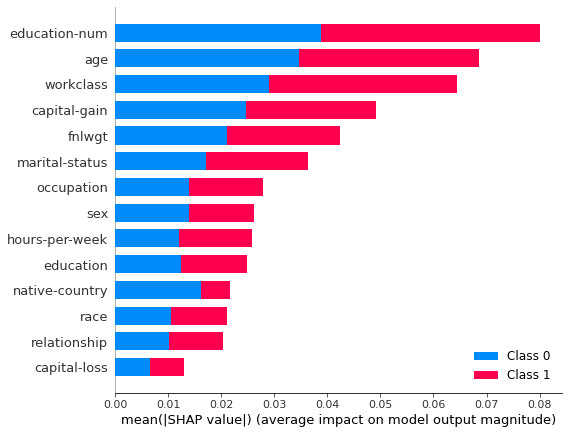

In [12]:
shap.summary_plot(shap_values, X_test)

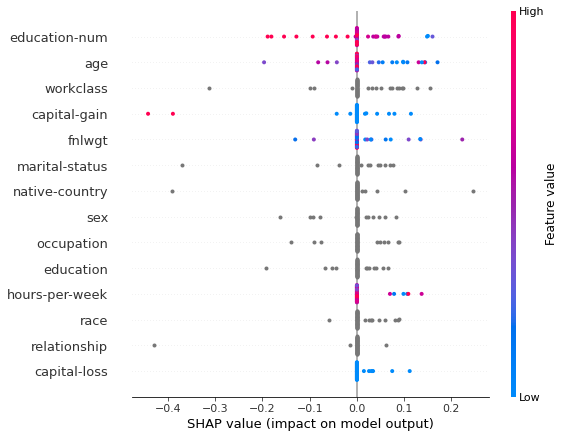

In [13]:
shap.summary_plot(shap_values[0], X_test)

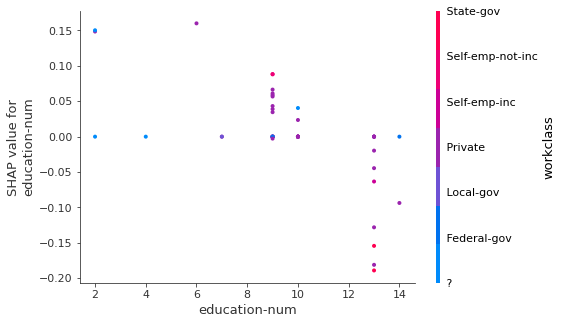

In [14]:
shap.dependence_plot("education-num", shap_values[0], X_test)

### Overall Feature Importance 

개별 예측을 설명하는 대신 각 피쳐가 AutoGluon의 일반적인 예측 정확도에 얼마나 기여하는지 알고 싶다면 Permutation Shuffling을 활용할 수 있습니다.

In [15]:
predictor.feature_importance(test_data)

Computing feature importance via permutation shuffling for 14 features using 50 rows with 3 shuffle sets...
	3.92s	= Expected runtime (1.31s per shuffle set)
	1.35s	= Actual runtime (Completed 3 of 3 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
capital-gain,0.066667,0.011547,0.004926,3,0.132832,0.000501
education-num,0.046667,0.011547,0.009902,3,0.112832,-0.019499
occupation,0.020000,0.000000,0.500000,3,0.020000,0.020000
workclass,0.020000,0.020000,0.112702,3,0.134602,-0.094602
age,0.020000,0.034641,0.211325,3,0.218497,-0.178497
hours-per-week,0.013333,0.011547,0.091752,3,0.079499,-0.052832
fnlwgt,0.013333,0.011547,0.091752,3,0.079499,-0.052832
capital-loss,0.006667,0.011547,0.211325,3,0.072832,-0.059499
sex,0.006667,0.023094,0.333333,3,0.138998,-0.125665
relationship,0.006667,0.011547,0.211325,3,0.072832,-0.059499


<br>

## 3. Multiclass Classification
다중(multi) 클래스 분류도 SHAP 적용이 가능합니다. 이번에는 개인 소득 대신 가족 관계(relationshop)를 예측하는 문제로 변경해서 훈련을 수행 후 SHAP을 확인해 보겠습니다.

In [16]:
label = 'relationship'

y_train = train_data[label]
y_test = test_data[label]
X_train = pd.DataFrame(train_data.drop(columns=[label]))
X_test = pd.DataFrame(test_data.drop(columns=[label]))

display(train_data.head())
print("Possible classes: \n", train_data[label].value_counts())

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
18828,40,Federal-gov,219266,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,>50K
27445,18,?,79990,11th,7,Never-married,?,Own-child,White,Male,0,0,35,United-States,<=50K
12294,59,State-gov,354948,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,3103,0,40,United-States,>50K
22959,32,Private,164197,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,60,United-States,>50K
24860,65,?,106161,Assoc-acdm,12,Married-civ-spouse,?,Husband,White,Male,0,0,40,United-States,<=50K


Possible classes: 
  Husband           203
 Not-in-family     129
 Own-child          73
 Unmarried          58
 Wife               27
 Other-relative     10
Name: relationship, dtype: int64


`problem_type`을 지정하지 않아도 AutoGluon에서 자동으로 처리하지만, 안전하게 `problem_type=multiclass`로 지정합니다.

In [17]:
predictor_multi = TabularPredictor(label=label, problem_type='multiclass').fit(train_data, time_limit=20)

No path specified. Models will be saved in: "AutogluonModels/ag-20210318_004833/"
Beginning AutoGluon training ... Time limit = 20s
AutoGluon will save models to "AutogluonModels/ag-20210318_004833/"
AutoGluon Version:  0.1.0
Train Data Rows:    500
Train Data Columns: 14
Preprocessing data ...
Train Data Class Count: 6
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    58508.81 MB
	Train Data (Original)  Memory Usage: 0.29 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...

	Ran out of time, stopping training early.


	0.48	 = Validation accuracy score
	9.15s	 = Training runtime
	0.39s	 = Validation runtime


Fitting model: WeightedEnsemble_L2 ... Training model for up to 19.89s of the -2.54s of remaining time.
	0.77	 = Validation accuracy score
	0.1s	 = Training runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 22.65s ...
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20210318_004833/")


In [18]:
baseline = X_train.sample(100) # X_train.mode() could also be reasonable baseline for both numerical/categorical features rather than an entire dataset.

ag_wrapper = AutogluonWrapper(predictor_multi, X_train.columns)
explainer = shap.KernelExplainer(ag_wrapper.predict_proba, baseline)

In [19]:
pd.DataFrame(np.mean(ag_wrapper.predict_proba(baseline),axis=0))

,0
Husband,0.376548
Not-in-family,0.274360
Other-relative,0.033338
Own-child,0.157980
Unmarried,0.099677
Wife,0.058097


In [20]:
print("Class Info: \n", predictor_multi.class_labels)

NSHAP_SAMPLES = 10  # how many samples to use to approximate each Shapely value, larger values will be slower
shap.initjs()

Class Info: 
 [' Husband', ' Not-in-family', ' Other-relative', ' Own-child', ' Unmarried', ' Wife']


class 중 Not-in-family에 대해서 SHAP을 plot해 보겠습니다.

In [21]:
ROW_INDEX = 0  # index of an example datapoint
class_of_interest = ' Not-in-family'  # can be any value in set(y_train)
class_index = predictor_multi.class_labels.index(class_of_interest)

single_datapoint = X_train.iloc[[ROW_INDEX]]
single_prediction = ag_wrapper.predict_proba(single_datapoint)

shap_values_single = explainer.shap_values(single_datapoint, nsamples=NSHAP_SAMPLES)
print("Shapely values: \n", {predictor_multi.class_labels[i]:shap_values_single[i] for i in range(len(predictor_multi.class_labels))})

print(f"Force_plot for class: {class_of_interest}")
shap.force_plot(explainer.expected_value[class_index], shap_values_single[class_index], X_train.iloc[ROW_INDEX,:])

  0%|          | 0/1 [00:00<?, ?it/s]

num_full_subsets = 0
remaining_weight_vector = [0.324082 0.175545 0.127669 0.105327 0.093624 0.087772 0.085981]
num_paired_subset_sizes = 6
weight_left = 1.0
np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 1.0
phi = [0.       0.       0.       0.       0.       0.       0.       0.       0.       0.       0.       0.       0.587231
 0.      ]
np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 1.0
phi = [ 0.       0.      -0.26328  0.       0.       0.       0.       0.       0.       0.       0.       0.       0.
  0.     ]
np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 1.0
phi = [-0.004412  0.       -0.016092  0.        0.        0.       -0.005605  0.        0.        0.        0.
  0.        0.        0.      ]
np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 1.0
phi = [-0.052803  0.       -0.074643  0.       -0.026316  0.        0.        0.        0.        0.        0.
  0.        0.        0.      ]
np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 1.0
phi = [ 0.        0. 

Shapely values: 
 {' Husband': array([[0.      , 0.      , 0.      , 0.      , 0.      , 0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
        0.      , 0.587231, 0.      ]]), ' Not-in-family': array([[ 0.     ,  0.     , -0.26328,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  0.     ]]), ' Other-relative': array([[-0.004412,  0.      , -0.016092,  0.      ,  0.      ,  0.      , -0.005605,  0.      ,  0.      ,  0.      ,
         0.      ,  0.      ,  0.      ,  0.      ]]), ' Own-child': array([[-0.052803,  0.      , -0.074643,  0.      , -0.026316,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
         0.      ,  0.      ,  0.      ,  0.      ]]), ' Unmarried': array([[ 0.      ,  0.      , -0.097195,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
         0.      ,  0.      ,  0.      ,  0.      ]]), ' Wife': array([[ 0.      ,  0.      , -0.046885,  0.      ,  0.   

In [22]:
shap_values = explainer.shap_values(X_test, nsamples=NSHAP_SAMPLES)

print(f"Force_plot for class: {class_of_interest}")
shap.force_plot(explainer.expected_value[class_index], shap_values[class_index], X_test)

  0%|          | 0/50 [00:00<?, ?it/s]

num_full_subsets = 0
remaining_weight_vector = [0.324082 0.175545 0.127669 0.105327 0.093624 0.087772 0.085981]
num_paired_subset_sizes = 6
weight_left = 1.0
np.sum(w_aug) = 14.000000000000002
np.sum(self.kernelWeights) = 1.0
phi = [ 0.        0.        0.        0.       -0.126569 -0.137613  0.        0.        0.        0.        0.
  0.        0.        0.      ]
np.sum(w_aug) = 14.000000000000002
np.sum(self.kernelWeights) = 1.0
phi = [0.       0.       0.093125 0.       0.252694 0.148988 0.       0.       0.       0.       0.       0.       0.
 0.      ]
np.sum(w_aug) = 14.000000000000002
np.sum(self.kernelWeights) = 1.0
np.sum(w_aug) = 14.000000000000002
np.sum(self.kernelWeights) = 1.0
phi = [-0.106312  0.        0.        0.       -0.027199  0.        0.        0.        0.        0.        0.
  0.        0.        0.      ]
np.sum(w_aug) = 14.000000000000002
np.sum(self.kernelWeights) = 1.0
phi = [ 0.        0.        0.        0.       -0.075275  0.        0.        0.       

remaining_weight_vector = [0.324082 0.175545 0.127669 0.105327 0.093624 0.087772 0.085981]
num_paired_subset_sizes = 6
weight_left = 1.0
np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 1.0
phi = [ 0.        0.        0.        0.        0.        0.        0.        0.       -0.308481  0.        0.
  0.        0.        0.      ]
np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 1.0
phi = [ 0.        0.        0.        0.        0.       -0.220895  0.        0.        0.        0.        0.
  0.        0.        0.      ]
np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 1.0
phi = [-0.001691  0.        0.        0.        0.       -0.017789  0.        0.        0.008888 -0.004666  0.
  0.        0.        0.      ]
np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 1.0
phi = [-0.04641   0.        0.        0.        0.       -0.096663  0.        0.        0.        0.        0.
  0.        0.        0.      ]
np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 1.0
phi = [ 0.        0. 

phi = [ 0.        0.       -0.202766  0.        0.        0.        0.        0.       -0.171376  0.        0.
  0.        0.        0.      ]
np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 1.0
phi = [ 0.        0.        0.        0.       -0.035292  0.        0.        0.        0.        0.        0.
  0.        0.       -0.019437]
np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 1.0
phi = [0.021126 0.       0.       0.       0.       0.       0.       0.       0.009819 0.       0.       0.       0.
 0.      ]
np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 1.0
phi = [0.438213 0.       0.       0.       0.       0.       0.       0.       0.       0.       0.       0.       0.
 0.      ]
np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 1.0
phi = [ 0.       -0.007727 -0.090989  0.        0.046934  0.        0.        0.        0.039203  0.        0.
  0.        0.        0.      ]
np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 1.0
phi = [ 0.        0.       -0.142591  0.   

phi = [-0.248859  0.        0.        0.        0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.      ]
np.sum(w_aug) = 13.999999999999998
np.sum(self.kernelWeights) = 1.0
phi = [-0.007342  0.       -0.006237  0.        0.        0.        0.        0.        0.        0.        0.
 -0.007573  0.        0.      ]
np.sum(w_aug) = 13.999999999999998
np.sum(self.kernelWeights) = 1.0
phi = [ 0.        0.       -0.024923  0.        0.       -0.065941 -0.007801  0.        0.        0.        0.
 -0.045582  0.        0.      ]
np.sum(w_aug) = 13.999999999999998
np.sum(self.kernelWeights) = 1.0
phi = [-0.080657  0.        0.        0.        0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.      ]
np.sum(w_aug) = 13.999999999999998
np.sum(self.kernelWeights) = 1.0
phi = [-0.025641 -0.005822  0.        0.        0.        0.        0.        0.        0.        0.        0.
 -0.010053  0.        0.      ]
num_full_subs

np.sum(self.kernelWeights) = 1.0
phi = [0.001356 0.       0.       0.008505 0.       0.016674 0.       0.013226 0.       0.       0.       0.       0.
 0.      ]
np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 1.0
phi = [ 0.        0.        0.       -0.051046  0.        0.02664   0.01407   0.        0.        0.        0.
  0.        0.        0.028117]
np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 1.0
phi = [0.       0.       0.       0.       0.       0.069704 0.       0.061706 0.086584 0.       0.       0.       0.049575
 0.      ]
np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 1.0
phi = [ 0.        0.        0.        0.        0.       -0.144252  0.        0.        0.139803  0.        0.
  0.        0.        0.      ]
num_full_subsets = 0
remaining_weight_vector = [0.324082 0.175545 0.127669 0.105327 0.093624 0.087772 0.085981]
num_paired_subset_sizes = 6
weight_left = 1.0
np.sum(w_aug) = 14.000000000000002
np.sum(self.kernelWeights) = 1.0
phi = [0.       0.       0.  

np.sum(self.kernelWeights) = 1.0
phi = [ 0.        0.       -0.024966  0.        0.       -0.071946  0.        0.        0.        0.        0.
  0.        0.        0.      ]
np.sum(w_aug) = 13.999999999999998
np.sum(self.kernelWeights) = 1.0
phi = [ 0.        0.       -0.032428  0.        0.       -0.038653  0.        0.        0.        0.        0.
  0.        0.       -0.019184]
np.sum(w_aug) = 13.999999999999998
np.sum(self.kernelWeights) = 1.0
phi = [-0.00603   0.        0.        0.        0.        0.063781  0.       -0.001833  0.        0.        0.
  0.       -0.085209  0.      ]
num_full_subsets = 0
remaining_weight_vector = [0.324082 0.175545 0.127669 0.105327 0.093624 0.087772 0.085981]
num_paired_subset_sizes = 6
weight_left = 1.0
np.sum(w_aug) = 14.000000000000002
np.sum(self.kernelWeights) = 1.0
phi = [ 0.        0.        0.        0.        0.       -0.349476  0.        0.        0.        0.        0.
  0.        0.        0.      ]
np.sum(w_aug) = 14.00000000000000

np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 1.0
phi = [-0.028885 -0.01033   0.        0.        0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.      ]
num_full_subsets = 0
remaining_weight_vector = [0.324082 0.175545 0.127669 0.105327 0.093624 0.087772 0.085981]
num_paired_subset_sizes = 6
weight_left = 1.0
np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 1.0
phi = [ 0.        0.       -0.065434  0.        0.       -0.141116  0.        0.        0.       -0.168633  0.
  0.        0.        0.      ]
np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 1.0
phi = [-0.210309  0.        0.        0.        0.        0.074431  0.        0.        0.        0.        0.
 -0.081978  0.        0.      ]
np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 1.0
phi = [-0.005034  0.        0.       -0.008287  0.010132  0.        0.        0.        0.        0.        0.
 -0.011027  0.        0.      ]
np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 1.0


np.sum(w_aug) = 14.000000000000002
np.sum(self.kernelWeights) = 1.0
phi = [-0.040296  0.        0.        0.        0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.      ]
num_full_subsets = 0
remaining_weight_vector = [0.324082 0.175545 0.127669 0.105327 0.093624 0.087772 0.085981]
num_paired_subset_sizes = 6
weight_left = 1.0
np.sum(w_aug) = 14.000000000000002
np.sum(self.kernelWeights) = 1.0
phi = [0.116445 0.       0.       0.       0.       0.19729  0.12936  0.       0.150954 0.       0.       0.       0.
 0.      ]
np.sum(w_aug) = 14.000000000000002
np.sum(self.kernelWeights) = 1.0
phi = [-0.11349   0.        0.        0.        0.       -0.120616  0.017552  0.        0.       -0.053233  0.
  0.        0.        0.      ]
np.sum(w_aug) = 14.000000000000002
np.sum(self.kernelWeights) = 1.0
phi = [ 0.        0.        0.        0.        0.       -0.016617 -0.001513  0.       -0.005853  0.        0.
  0.        0.        0.      ]
np.sum(w_aug

phi = [ 0.        0.        0.076182  0.        0.        0.        0.        0.       -0.122986  0.        0.
  0.        0.        0.027784]
num_full_subsets = 0
remaining_weight_vector = [0.324082 0.175545 0.127669 0.105327 0.093624 0.087772 0.085981]
num_paired_subset_sizes = 6
weight_left = 1.0
np.sum(w_aug) = 14.000000000000002
np.sum(self.kernelWeights) = 1.0
phi = [0.       0.       0.       0.       0.       0.       0.       0.       0.148394 0.       0.       0.       0.
 0.438976]
np.sum(w_aug) = 14.000000000000002
np.sum(self.kernelWeights) = 1.0
phi = [-0.264336  0.        0.        0.        0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.      ]
np.sum(w_aug) = 14.000000000000002
np.sum(self.kernelWeights) = 1.0
phi = [-0.008311  0.       -0.004575  0.        0.        0.        0.        0.       -0.006004  0.       -0.005509
  0.        0.        0.      ]
np.sum(w_aug) = 14.000000000000002
np.sum(self.kernelWeights) = 1.0
phi = 

Force_plot for class:  Not-in-family


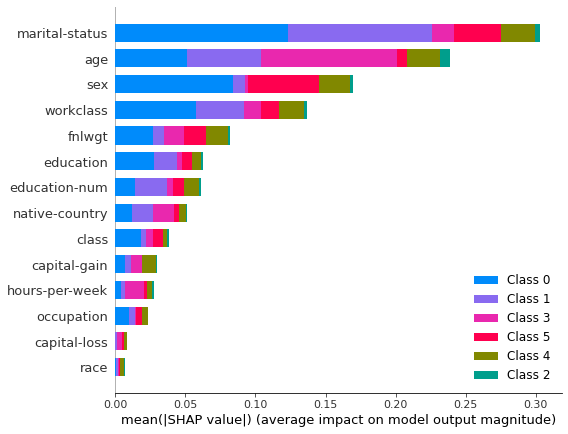

{'Class 0': ' Husband', 'Class 1': ' Not-in-family', 'Class 2': ' Other-relative', 'Class 3': ' Own-child', 'Class 4': ' Unmarried', 'Class 5': ' Wife'}


In [23]:
shap.summary_plot(shap_values, X_test)
print({"Class "+str(i) : predictor_multi.class_labels[i] for i in range(len(predictor_multi.class_labels))})

Dependence_plot for class:  Not-in-family  and for feature: marital-status 



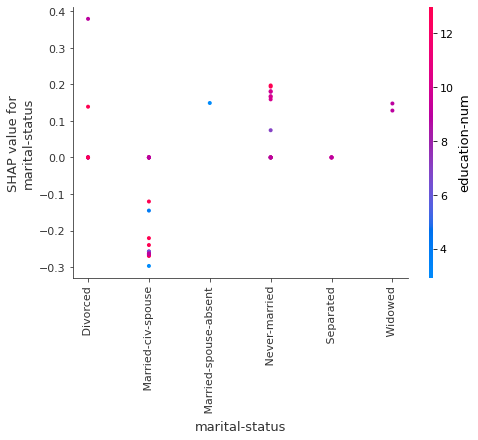

In [24]:
dependence_feature = "marital-status"
print(f"Dependence_plot for class: {class_of_interest}  and for feature: {dependence_feature} \n")

shap.dependence_plot(dependence_feature, shap_values[class_index], X_test)

In [25]:
predictor.feature_importance(test_data)

Computing feature importance via permutation shuffling for 14 features using 50 rows with 3 shuffle sets...
	4.1s	= Expected runtime (1.37s per shuffle set)
	1.36s	= Actual runtime (Completed 3 of 3 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
capital-gain,0.066667,0.011547,0.004926,3,0.132832,0.000501
education-num,0.046667,0.011547,0.009902,3,0.112832,-0.019499
occupation,0.020000,0.000000,0.500000,3,0.020000,0.020000
workclass,0.020000,0.020000,0.112702,3,0.134602,-0.094602
age,0.020000,0.034641,0.211325,3,0.218497,-0.178497
hours-per-week,0.013333,0.011547,0.091752,3,0.079499,-0.052832
fnlwgt,0.013333,0.011547,0.091752,3,0.079499,-0.052832
capital-loss,0.006667,0.011547,0.211325,3,0.072832,-0.059499
sex,0.006667,0.023094,0.333333,3,0.138998,-0.125665
relationship,0.006667,0.011547,0.211325,3,0.072832,-0.059499
